In [15]:
from sklearn import metrics as skmetrics
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import scipy.ndimage as ndimage 


import glob, os, pandas as pd
import numpy as np

import tifffile

import matplotlib.pyplot as plt
%matplotlib inline

root = os.path.expanduser('~')
feat_root = os.path.join(root, '_FrancisCrickProject/features/')
and_feat = pd.read_csv(feat_root + 'feature_matrix.csv', header=0)

# read ground truth
cnt = tifffile.imread(root + '/_FrancisCrickProject/ROI_1656-6756-329_manual/ROI_1656-6756-329_z0090.tif')
cpoints = np.nonzero(cnt > 1)
image = tifffile.imread(root + '/_FrancisCrickProject/ROI_1656-6756-329/ROI_1656-6756-329_z0090.tiff')

cnt_filled = ndimage.binary_fill_holes(cnt>1).astype(int)
#plt.imshow(cnt_filled)



Index([u'canny', u'centroid_1', u'centroid_4', u'edge_mask', u'gaussian',
       u'nuclei_1', u'nuclei_2', u'seg_1_4000'],
      dtype='object')


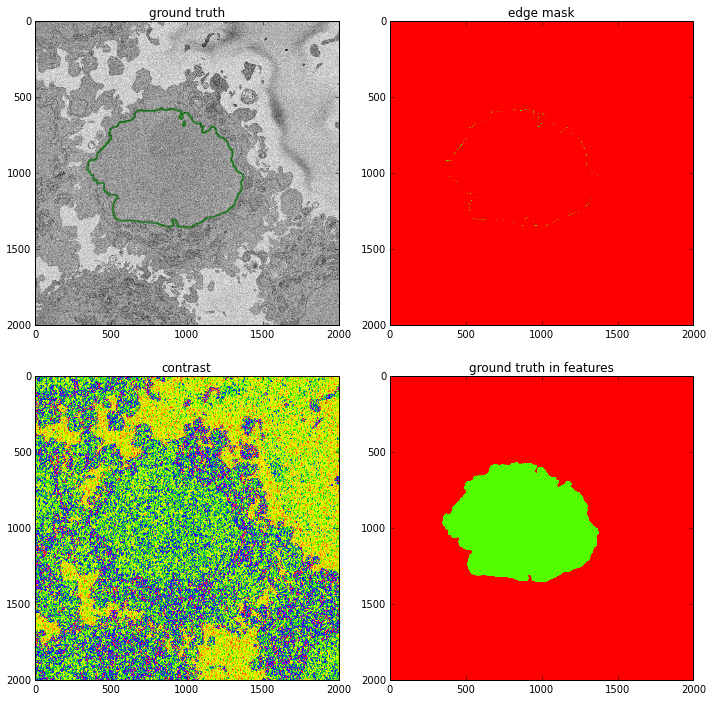

In [6]:


print and_feat.columns


# add ground truth and features to the dataframe
df_contr = pd.read_csv(os.path.join(feat_root, 'contrast.csv'), compression='gzip')
and_feat['contrast'] = np.ndarray.flatten(df_contr.as_matrix().T)

df_dissim = pd.read_csv(os.path.join(feat_root, 'dissimilarity.csv'), compression='gzip')
and_feat['dissimilarity'] = np.ndarray.flatten(df_dissim.as_matrix().T)

and_feat['gt'] = np.ndarray.flatten((cnt_filled).T)



# test plot
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr = axarr.flatten()

axarr[0].plot(cpoints[1], cpoints[0], 'g.', markersize=0.1, linewidth = 0.1, alpha=0.5)
axarr[0].imshow(image, cmap = 'gray')
axarr[0].set_title('ground truth')

f = np.reshape(and_feat['edge_mask'], (2000, 2000)).T
axarr[1].imshow(f, cmap='prism')
axarr[1].set_title('edge mask')

f1 = np.reshape(and_feat['contrast'], (2000, 2000)).T
axarr[2].imshow(f1, cmap='prism')
axarr[2].set_title('contrast')

f2 = np.reshape(and_feat['gt'], (2000, 2000)).T
axarr[3].imshow(f2, cmap='prism')
axarr[3].set_title('ground truth in features')

plt.tight_layout()
plt.show()

fig.savefig(feat_root + 'joined_data.png', dpi = 100, bbox_inches='tight')


In [7]:
# save a complete dataframe with all features and binarised ground truth
and_feat.to_csv(os.path.join(feat_root, 'AV_MR_features.csv'), compression='gzip', index=False)

In [8]:
# if prep work already done, start here

# read all data
data = pd.read_csv(os.path.join(feat_root, 'AV_MR_features.csv'), compression='gzip', header = 0)
cols = (data.columns)

norm_feat = preprocessing.normalize(data[cols[:-1]])
norm_feat = pd.DataFrame(norm_feat, columns = cols[:-1])

Y = data['gt']

'''
# plot to see if data are normalised correctly
test = np.reshape(norm_feat['contrast'], (2000, 2000)).T
plt.imshow(f1, cmap='prism')
plt.title('normalised contrast')
'''
#print(Y.mean()) 0.144

0.144221


In [19]:
# split data into train and test sets

TEST_SIZE = 0.5
X_train = norm_feat.ix[ : len(norm_feat)*(1 - TEST_SIZE) -1, :]
Y_train = Y.ix[ : (len(Y)*(1 - TEST_SIZE)) - 1]

Y_test = Y.ix[len(Y)*(1 - TEST_SIZE) :]
X_test = norm_feat.ix[len(norm_feat)*(1 - TEST_SIZE) :, :]

print ('X train/test')
print (X_train.shape)
print(X_test.shape)

print ('\nY train/test')
print (Y_train.shape)
print (Y_test.shape)



def get_scores(str_clf_descr, classifier, sX_train=X_train, sX_test=X_test):
    df = pd.DataFrame(columns = ['method', 'parameters', 't_precision', 't_recall', 't_AUC', 'v_precision', 'v_recall', 'v_AUC'])
    sXv = sX_test
    sXt = sX_train
    train_clf = classifier.predict(sXt)
    test_clf = classifier.predict(sXv)
    
    df.method = [str_clf_descr]
    df.parameters = [str(classifier)]
    df.t_precision = [round(skmetrics.precision_score(Y_train, train_clf), 2)]
    df.t_recall = [round(skmetrics.recall_score(Y_train, train_clf), 2)]
    df.t_AUC = [round(skmetrics.roc_auc_score(Y_train, train_clf), 2)]

    df.v_precision = [round(skmetrics.precision_score(Y_test, test_clf), 2)]
    df.v_recall = [round(skmetrics.recall_score(Y_test, test_clf), 2)]
    df.v_AUC = [round(skmetrics.roc_auc_score(Y_test, test_clf), 2)]
    return df



def grid_search(classifier, params, score, Xtrain=X_train, Ytrain=Y_train, Xtest=X_test, Ytest=Y_test):
        print("# Tuning hyper-parameters for %s" % score)
        print ''

        classifier.fit(Xtrain, Ytrain)
        print("Best parameters set found on development set:")
        print(classifier.best_params_)
        print ''
        print("Detailed classification report:")
        print ''

        y_pred = classifier.predict(Xtest)
        print(skmetrics.classification_report(Ytest, y_pred))
        print ''
        
        
def test_best_classifier(best_classifiers, clf_type, nr_times=100):
    '''
    best_classifiers: list of {score : classifier} dictionaries.
    clf_type: classifier type in sklearn (RF, GradientBoost, ...).
    features: feature subset to use.
    nr_times: how many times to run a classifier on the data.
    
    Runs tests nr_times on scaled features subset "features".
    Returns dataFrame with classifier type, optimisation score, and train+validation summary.
    '''

    df = pd.DataFrame() # contains data for all classifiers
    
    for clf in best_classifiers:
        tmpdf = pd.DataFrame() # contains data for one classifer
        score = clf.keys()[0]
        for i in range(100):        
            clf.values()[0].fit(X_train, Y_train)
            scores = get_scores(clf_type, clf.values()[0])
            scores['opt_score'] = score
            tmpdf = tmpdf.append(scores, ignore_index=True)
        
        df = df.append(tmpdf, ignore_index=True)
        
    return df        

X train/test
(2000000, 10)
(2000000, 10)

Y train/test
(2000000,)
(2000000,)


In [20]:
mlp_params = [{'hidden_layer_sizes': [(80, 10, 4), (8,4,2), (25, 5, 2), (12, 6, 2)],\
                   'solver': ['adam'],\
                   'early_stopping' : [True],\
                   'learning_rate':['adaptive'],\
                   'alpha' : [1e-5, 0.001, 0.01, 0.1, 1],\
                   'max_iter' : [100]
                  }]

#mlp_params = [{}]
clfs = []
resdf = pd.DataFrame()
scores = ['precision', 'recall', 'f1']
for s in scores:
    clf = GridSearchCV(MLPClassifier(), mlp_params, scoring=s)
    clf.fit(X_train, Y_train)
    best = clf.best_estimator_
    clfs.append(best)
    idf = test_best_classifier([{s:best}], '_NN_')
    resdf = resdf.append(idf, ignore_index=True)


/home/marina/_notebook/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
resdf.to_csv(os.path.join(feat_root, 'NN_results.csv'), index=False)

In [27]:
import pickle


cl = zip(clfs, scores)

# write best classifier to file
for c in cl:
    pickle.dump(c[0], open(os.path.join(feat_root, \
                            'NN_clf_' + '_score-' + c[1] + '.sav'), 'wb'))

In [79]:
print resdf.ix[resdf['t_AUC'].idxmax()].parameters

print resdf.columns

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(80, 10, 4), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Index([u'method', u'parameters', u't_precision', u't_recall', u't_AUC',
       u'v_precision', u'v_recall', u'v_AUC', u'opt_score'],
      dtype='object')


In [42]:
import time

t0 = time.time()

best_class = clfs[0]
pred = clfs[0].predict(X_test)
print skmetrics.classification_report(pred, Y_test)

tN = time.time()
print 'time in sec', tN - t0

             precision    recall  f1-score   support

          0       1.00      0.99      1.00   1823531
          1       0.94      1.00      0.97    176469

avg / total       0.99      0.99      0.99   2000000

time in sec 13.8036880493


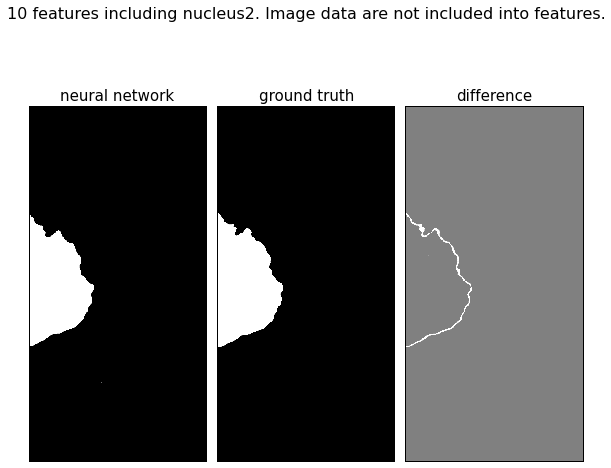

In [85]:
fig, axx = plt.subplots(1,3, figsize=(8,8))
#axx[0].imshow(np.reshape(Y_test, (1000, 2000)).T, cmap='gray', alpha=0.3)
axx[0].imshow(np.reshape(pred, (1000, 2000)).T, cmap='gray',)
axx[0].set_xticks([])
axx[0].set_yticks([])
axx[0].set_title('neural network', fontsize=15)

axx[1].imshow(cnt_filled[:,1000:], cmap='gray')
axx[1].set_xticks([])
axx[1].set_yticks([])
axx[1].set_title('ground truth', fontsize=15)


axx[2].imshow(cnt_filled[:,1000:] - np.reshape(pred, (1000, 2000)).T, cmap='gray')
axx[2].set_xticks([])
axx[2].set_yticks([])
axx[2].set_title('difference', fontsize=15)

fig.suptitle('10 features including nucleus2. Image data are not included into features.', \
             fontsize=16)
plt.tight_layout()

fig.savefig(os.path.join(feat_root, 'NN_results.png'), dpi=150, bbox_inches='tight')

In [97]:
# Jacquard index  = intersection / union

intersect = Y_test & pred
union = Y_test | pred
print 'Jacquard =', sum(intersect)/float(sum(union))

Jacquard = 0.941086437135
